# Benchmarking computational time

In this Jupyter Notebook, we demonstrate how to benchmark the computational time of various algorithms.
While running these algorithms, we recorded the computational time using `nb.record` or `nb.utils.monitor` (see other Notebooks), and the records can be parsed using `nb.utils.parse_record`.

To compare computational time across template spaces (fsavg, fslr, and onavg), it is important that the computations are performed on the same node of the HPC cluster and in the same environment.
`nb.utils.parse_record` has an `assert_node` parameter, which can be used to ensure that the computations were performed on a specific node.

The computational times in this Notebook were based on the latest s-nodes of the Discovery HPC cluster, and they are faster in general. However, the differences between template spaces still remain, and the computational times are shorter when using `onavg` instead of other template spaces.

In [1]:
import numpy as np
import neuroboros as nb
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

This example uses the `ico32` resolution. For other resolutions, simply change the setting here.

In [2]:
ico = 32
spaces = [f'{a}-ico{b}' for a in ['fsavg', 'fslr', 'onavg'] for b in [ico]]
dsets = ['budapest', 'raiders']

In [3]:
colors = np.array(sns.color_palette('tab10'))
np.set_printoptions(4, linewidth=200)
if os.path.exists('Arial.ttf'):
    from matplotlib import font_manager
    font_manager.fontManager.addfont('Arial.ttf')
mpl.rcParams['font.family'] = 'Arial'

## Hyperalignment template creation

This section shows the computational time to create a functional template for hyperalignment, which is also known as a common space.

The computational time is proportional to the number of participants. In this case, the time for these two datasets (_n_ = 21 and 23, respectively, for _Budapest_ and _Raiders_) is similar to the StudyForrest dataset (_n_ = 15), even though the computations were performed on a faster HPC node for these two datasets.

To accurately record the CPU time, the computations were performed in a single-threaded manner. Typically, these computations are performed in parallel and are much faster (e.g., about half an hour per hemisphere with `n_jobs=40`).

In [4]:
tpl_time = {}
for dset_name in dsets:
    for space in spaces:
        t = [
            nb.utils.parse_record(
                f'ha_tpl/{dset_name}/{space}_{lr}h_1st-half_20mm.npy.finish',
                assert_node='s01')[0] / 1e9
            for lr in 'lr']
        tpl_time[dset_name, space] = np.array(t)

Each entry in the dictionary is a NumPy array with 2 values, which is the computational time in seconds for the left and right hemispheres, respectively.

In [5]:
tpl_time[dset_name, space].shape

(2,)

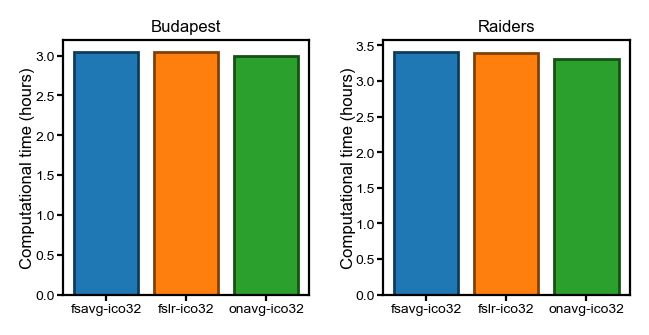

In [6]:
fig, axs = plt.subplots(1, 2, figsize=[_/2.54 for _ in (8, 4)], dpi=200)
for dset_name, ax in zip(dsets, axs):
    for i, space in enumerate(spaces):
        c = colors[i]
        ax.bar(i, tpl_time[dset_name, space].sum() / 3600, label=space,
              color=c, ec=c * 0.5)
    ax.set_title(dset_name.capitalize(), size=6, pad=3)
    ax.set_xticks(np.arange(3), spaces)
    ax.set_ylabel('Computational time (hours)', size=6, labelpad=0)
    ax.tick_params('both', size=2, pad=1, labelsize=5)
fig.subplots_adjust(left=0.08, right=0.98, top=0.9, bottom=0.09, wspace=0.3)
plt.savefig('computational_time_template.png', dpi=300, transparent=True)
plt.show()

## Hyperalignment transformations

This section is the computational time of hyperalignment transformation matrices, based on the orthogonal Procrustes algorithm and the warp hyperalignment algorithm, respectively.

In [7]:
flavors = ['procr', 'ridge']

xfm_time = {}
for dset_name in dsets:
    dset = nb.dataset(dset_name)
    sids = dset.subjects
    for space in spaces:
        folder = f'ha_xfm/{dset_name}/{space}_1st-half'
        for flavor in ['procr', 'ridge']:
            tt = []
            for sid in sids:
                t = [nb.utils.parse_record(
                         f'{folder}/{sid}_{lr}h_{flavor}_to-tmpl_20mm.npz.finish',
                         assert_node='s01') / 1e9
                     for lr in 'lr']
                tt.append(np.array(t))
            tt = np.array(tt)
            xfm_time[dset_name, space, flavor] = tt

Each entry in the dictionary is a NumPy array, and its shape is `(number of subjects, two hemispheres, CPU/wall time)`.

In [8]:
tt.shape

(23, 2, 2)

Here we show the average CPU time across participants.

The error bars are standard errors of the mean (SEs).
However, the SEs are very small, and the error bars are hardly visible.

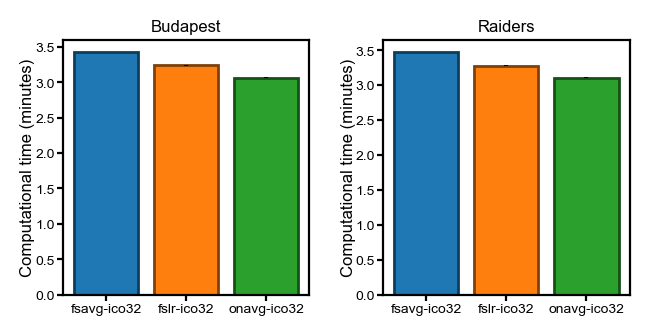

In [9]:
flavor = 'procr'

fig, axs = plt.subplots(1, 2, figsize=[_/2.54 for _ in (8, 4)], dpi=200)
for dset_name, ax in zip(dsets, axs):
    for i, space in enumerate(spaces):
        t = xfm_time[dset_name, space, flavor].sum(axis=1)[:, 0] / 60
        m = t.mean(axis=0)
        se = t.std(axis=0, ddof=1) / np.sqrt(len(t))
        c = colors[i]
        ax.bar(i, m, yerr=se, label=space, color=c, ec=c * 0.5)
    ax.set_title(dset_name.capitalize(), size=6, pad=3)
    ax.set_xticks(np.arange(3), spaces)
    # ax.set_yticks(np.arange(5) * 0.5)
    ax.set_ylabel('Computational time (minutes)', size=6, labelpad=0)
    ax.tick_params('both', size=2, pad=1, labelsize=5)
fig.subplots_adjust(left=0.08, right=0.98, top=0.9, bottom=0.09, wspace=0.3)
plt.savefig(f'computational_time_{flavor}.png', dpi=300, transparent=True)
plt.show()

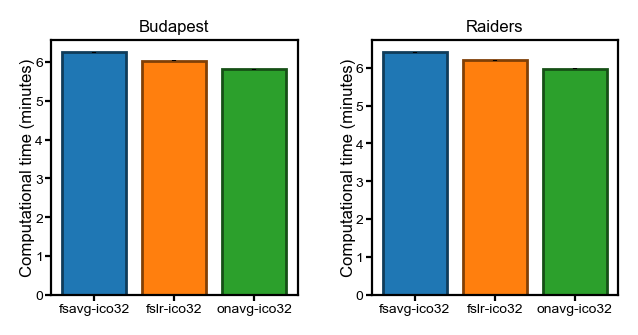

In [10]:
flavor = 'ridge'

fig, axs = plt.subplots(1, 2, figsize=[_/2.54 for _ in (8, 4)], dpi=200)
for dset_name, ax in zip(dsets, axs):
    for i, space in enumerate(spaces):
        t = xfm_time[dset_name, space, flavor].sum(axis=1)[:, 0] / 60
        m = t.mean(axis=0)
        se = t.std(axis=0, ddof=1) / np.sqrt(len(t))
        c = colors[i]
        ax.bar(i, m, yerr=se, label=space, color=c, ec=c * 0.5)
    ax.set_title(dset_name.capitalize(), size=6, pad=3)
    ax.set_xticks(np.arange(3), spaces)
    # ax.set_yticks(np.arange(6) * 0.5)
    ax.set_ylabel('Computational time (minutes)', size=6, labelpad=0)
    ax.tick_params('both', size=2, pad=1, labelsize=5)
fig.subplots_adjust(left=0.08, right=0.98, top=0.9, bottom=0.09, wspace=0.3)
plt.savefig(f'computational_time_{flavor}.png', dpi=300, transparent=True)
plt.show()

## Movie segment classification

In [11]:
clf_time = {}
train_dur, test_dur = '1st-half', '2nd-half'
size = 5
radius = 20
align_radius = 20

for dset_name in dsets:
    dset = nb.dataset(dset_name)
    sids = dset.subjects
    for space in spaces:
        for align in ['surf', 'procr', 'ridge']:
            tt = []
            for sid in sids:
                folder = f'sl_clf/{dset_name}/{space}_{align}_{align_radius}mm'\
                    f'_{train_dur}_{test_dur}_{size}TRs'
                t = [nb.utils.parse_record(
                         f'{folder}/{sid}_{lr}h_{radius}mm.npy.finish',
                         assert_node='s19') / 1e9
                     for lr in 'lr']
                tt.append(np.array(t))
            tt = np.array(tt)
            clf_time[dset_name, space, align] = tt

Each entry in the dictionary is a NumPy array, and its shape is `(number of subjects, two hemispheres, CPU/wall time)`.

In [12]:
tt.shape

(23, 2, 2)

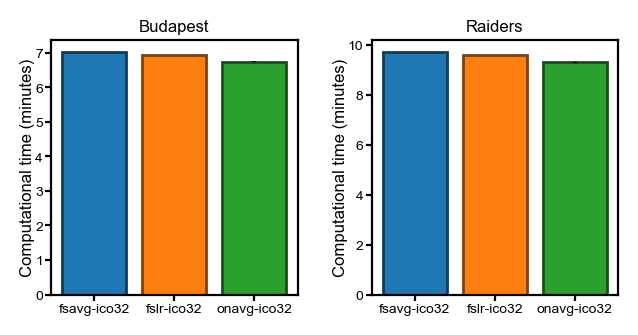

In [13]:
fig, axs = plt.subplots(1, 2, figsize=[_/2.54 for _ in (8, 4)], dpi=200)
for dset_name, ax in zip(dsets, axs):
    for i, space in enumerate(spaces):
        tt = np.array([clf_time[dset_name, space, align].sum(axis=1)[:, 0]
                       for align in ['surf', 'procr', 'ridge']])
        t = tt.mean(axis=0) / 60
        m = t.mean(axis=0)
        se = t.std(axis=0, ddof=1) / np.sqrt(len(t))
        c = colors[i]
        ax.bar(i, m, yerr=se, label=space, color=c, ec=c * 0.5)
    ax.set_title(dset_name.capitalize(), size=6, pad=3)
    ax.set_xticks(np.arange(3), spaces)
    # ax.set_yticks(np.arange(6) * 0.5)
    ax.set_ylabel('Computational time (minutes)', size=6, labelpad=0)
    ax.tick_params('both', size=2, pad=1, labelsize=5)
fig.subplots_adjust(left=0.08, right=0.98, top=0.9, bottom=0.09, wspace=0.3)
plt.savefig(f'computational_time_clf.png', dpi=300, transparent=True)
plt.show()

## Representational similarity analysis

Due to the nature of the RSA analysis, the computational time was recorded separately for each searchlight to avoid storing the representational dissimilarity matrices (RDMs).

It is time-consuming to load these records (one file per searchlight), and therefore we use a summary file to store all the numbers to avoid loading these records repetitively.

In [14]:
rsa_time_fn = f'rsa_time_ico{ico}.pkl'
if not os.path.exists(rsa_time_fn):
    rsa_time = {}
    train_dur, test_dur = '1st-half', '2nd-half'
    radius = 20
    align_radius = 20
    metric = 'correlation'
    
    for align in ['surf', 'procr', 'ridge']:
        for dset_name, node in zip(dsets, ['s19', 's19']):
            for space in spaces:
                folder = f'sl_rsa_isc/{dset_name}/{space}_{align}_'\
                         f'{align_radius}_{test_dur}'
                tt = []
                for lr in 'lr':
                    sls = nb.sls(lr, radius, space=space,
                                 center_space=space.split('-')[0] + '-ico32')
                    for sl_idx in range(len(sls)):
                        t = nb.utils.parse_record(
                            f'{folder}/{lr}h_{radius}mm_{metric}/'\
                            f'{sl_idx:05d}.npz.timing',
                            assert_node=node,
                        ) / 1e9
                        tt.append(t)
                tt = np.array(tt)
                rsa_time[dset_name, space, align] = tt
    nb.save(rsa_time_fn, rsa_time)

Each entry in the dictionary is a NumPy array with two dimensions. The first is the number of vertices, and the second is whether the recorded time is CPU time or wall time.

The recorded computational time for each searchlight is the total time across all participants. We divide it by the number of participants to get the computational time per participant, which is then summed up across searchlights.

In this analysis, the SE is the SE across repetitions (3 alignment methods, which theoretically have the same computational complexity).

In [15]:
rsa_time = nb.load(rsa_time_fn)

In [16]:
rsa_time[dset_name, space, align].shape

(19341, 2)

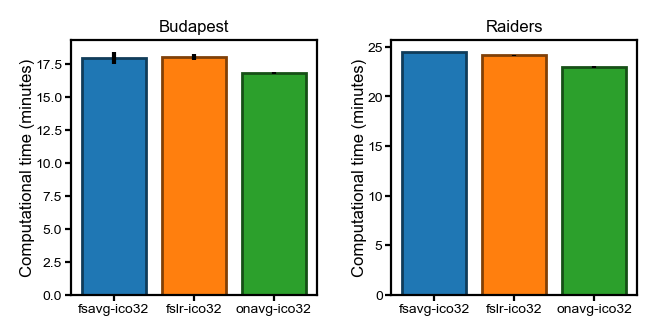

In [17]:
fig, axs = plt.subplots(1, 2, figsize=[_/2.54 for _ in (8, 4)], dpi=200)
for dset_name, ax in zip(dsets, axs):
    ns = {'budapest': 21, 'raiders': 23}[dset_name]
    for i, space in enumerate(spaces):
        tt = [rsa_time[dset_name, space, align].sum(axis=0)[0]
              for align in ['surf', 'procr', 'ridge']]
        tt = np.array(tt) / 60 / ns
        m = tt.mean()
        se = tt.std(ddof=1) / np.sqrt(len(tt))
        c = colors[i]
        ax.bar(i, m, yerr=se, label=space, color=c, ec=c * 0.5)
    ax.set_title(dset_name.capitalize(), size=6, pad=3)
    ax.set_xticks(np.arange(3), spaces)
    # ax.set_yticks(np.arange(0, tt.max()+0.2, 0.2))
    ax.set_ylabel('Computational time (minutes)', size=6, labelpad=0)
    ax.tick_params('both', size=2, pad=1, labelsize=5)
fig.subplots_adjust(left=0.08, right=0.98, top=0.9, bottom=0.09, wspace=0.3)
plt.savefig(f'computational_time_rsa.png', dpi=300, transparent=True)
plt.show()